In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics import tsaplots
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

MY INITIAL INTENTION OVER A MONTH AGO WAS TO EXPLORE THIS PROJECT AND PUT IN THE EFFORT IT DESERVES. UNFORTUNATELY CIRCUMSTANCES CHANGED AND SINCE THE PRIMARY REASONS BEHIND UNDERTAKING THE PROJECT WAS INTEREST RATHER THAN CAREER DRIVEN/MONETARY GOALS I MAKE NO EXCUSES FOR NOT DUTIFULY UNDERTAKING ALL RELEVANT ASPECTS OF THE "WEAPONS OF MATH DESTRUCTION."

FIRST SECTION PLOTS RESIDUAL FOR PARTITIONED LR MODEL AND UNPARTIONED LR MODEL
The intent is to highlight potential datetime cycle in predicted versus actual

In [2]:
#MODEL 1 Rule of Thumb Division of data into <60 and >=60f  Residuals from TEST
residuals = pd.read_pickle('residualsJan.pki')  #load previously created training data


Impact of apparent hour and day of week cycle on residuals 

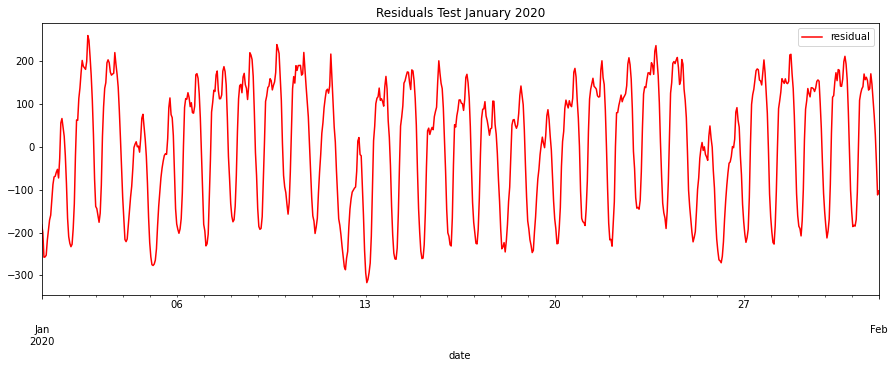

In [3]:

fig, ax = plt.subplots(figsize=(15, 5))
residuals.residual.plot(ax=ax,style='r-')  #index is used as default x axis

plt.title('Residuals Test January 2020')
ax.legend()
plt.show() 

In [4]:
#MODEL 2 OVER ENTIRE TRAIN DATA 

train=pd.read_pickle('train3Mod2.pki')
test=pd.read_pickle('test3mod2.pki')
#train.index = pd.DatetimeIndex(train.index).to_period('H')

Impact of apparent seasonal cycle on residuals with pssible day of week? 
However seems like could still be significant error component when looking at just one year
No apparent trend component in actual data

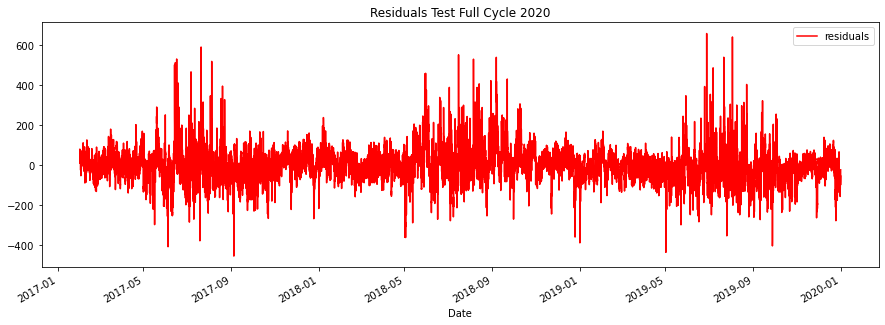

In [5]:

fig, ax = plt.subplots(figsize=(15, 5))
train.residuals.plot(ax=ax,style='r-')  #index is used as default x axis

plt.title('Residuals Test Full Cycle 2020')
ax.legend()
plt.show() 

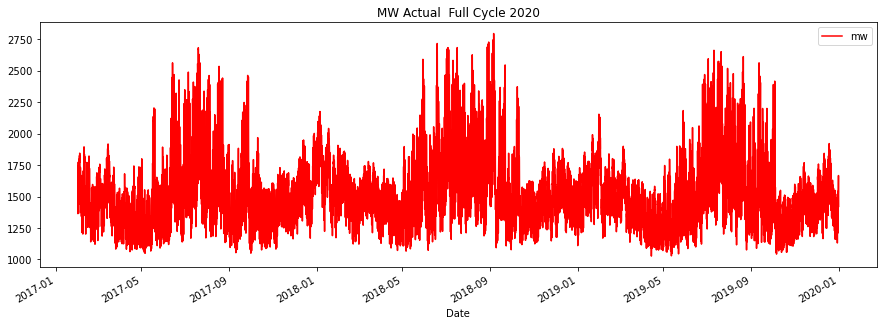

In [6]:

fig, ax = plt.subplots(figsize=(15, 5))
train.mw.plot(ax=ax,style='r-')  #index is used as default x axis

plt.title('MW Actual  Full Cycle 2020')
ax.legend()
plt.show() 

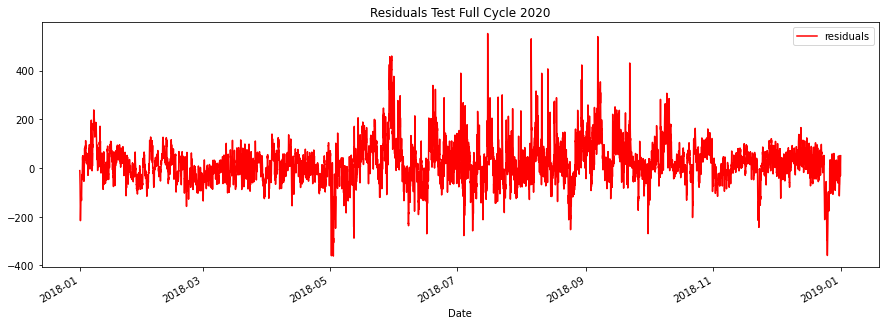

In [7]:

fig, ax = plt.subplots(figsize=(15, 5))
train.loc['2018-01-01':'2018-12-31'].residuals.plot(ax=ax,style='r-')  #index is used as default x axis

plt.title('Residuals Test Full Cycle 2020')
ax.legend()
plt.show() 

Conclude that variation between predicted appers to be both seasonal and time of day related. However, there is no perceived trend in terms of MW consumption growth over the period 2017-2019

Explore the use of exponential smoothing to reduce residual. In this case since the data variation is seasonal and no trend is apparent select Winters exponential smoothing model.

Looking at the forecast using Seasonal Additive smoothing

In [8]:

tes = ExponentialSmoothing(train.residuals, trend=None, seasonal='add', seasonal_periods=24)
residuals_tes = tes.fit()
print(residuals_tes.summary())


C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


                       ExponentialSmoothing Model Results                       
Dep. Variable:                residuals   No. Observations:                25536
Model:             ExponentialSmoothing   SSE                       35661159.883
Optimized:                         True   AIC                         184976.771
Trend:                             None   BIC                         185188.615
Seasonal:                      Additive   AICC                        184976.835
Seasonal Periods:                    24   Date:                 Thu, 27 May 2021
Box-Cox:                          False   Time:                         10:57:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9231499                alpha                 True
smoothing_seasonal       

In [9]:
#LOOK AT THE RESULTS FROM SEVERAL PERSPECTIVES
forecast = pd.DataFrame(residuals_tes.forecast(744))
forecast.index = test.index.copy()
forecast.head()


C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,0
Date,
2020-01-01 00:53:00,-27.723152
2020-01-01 01:53:00,-27.923149
2020-01-01 02:53:00,-29.875268
2020-01-01 03:53:00,-32.598129
2020-01-01 04:53:00,-36.026114


In [10]:
print("Additive Mean ",forecast.mean(), "Additive Variance: ",forecast.var())

Additive Mean  0   -28.957824
dtype: float64 Additive Variance:  0    49.476528
dtype: float64


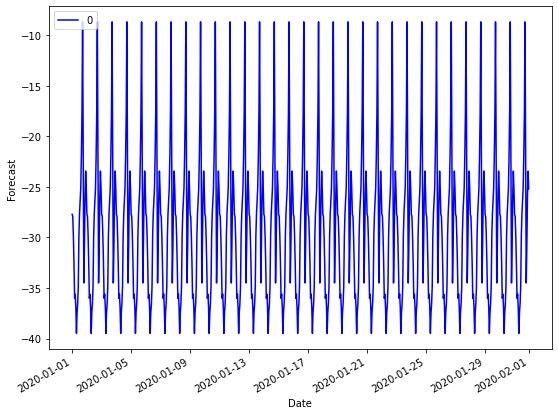

In [11]:


ax1 = forecast.plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('Forecast')
ax1.set_xlabel('Date')

plt.show()

INICATES AN IMPROVEMENT ON OUR BASIS MODEL BUT BEFORE EXAMINING IN DETAIL LETS JUST:

For comparison  see how Multiplicative Seasonal Smoothing compares. However, note tht the method requies all values to be positive. So normalise to positive.


In [12]:
print("Minimum: ",train["residuals"].min())

Minimum:  -454.35757841193345


In [13]:
#NOT SURE WHERE THAT OUTLYING DATA CAME FROM AND HOW UN REPRESENTATIVE IT IS...
# THE DATA CHARTING SUGGESTS ITS NOT...BUT WE WILL NORMALISE ALL THE DATA

train["residuals_nn"]=train["residuals"]+460

In [14]:
tes_mul = ExponentialSmoothing(train.residuals_nn, trend=None, seasonal='mul', seasonal_periods=24)
residuals_tes_mul = tes_mul.fit()
print(residuals_tes_mul.summary())



C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


                       ExponentialSmoothing Model Results                       
Dep. Variable:             residuals_nn   No. Observations:                25536
Model:             ExponentialSmoothing   SSE                       35665930.805
Optimized:                         True   AIC                         184980.187
Trend:                             None   BIC                         185192.031
Seasonal:                Multiplicative   AICC                        184980.251
Seasonal Periods:                    24   Date:                 Thu, 27 May 2021
Box-Cox:                          False   Time:                         10:57:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9478563                alpha                 True
smoothing_seasonal       

In [15]:
#EXTRACT THE FORECASTS AND DE NORMALISE
forecast_mul = pd.DataFrame(residuals_tes_mul.forecast(744))
forecast_mul.index = test.index.copy()
forecast_mul=forecast_mul-460
forecast_mul.head()

C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,0
Date,
2020-01-01 00:53:00,-29.477168
2020-01-01 01:53:00,-32.093008
2020-01-01 02:53:00,-35.467910
2020-01-01 03:53:00,-38.322371
2020-01-01 04:53:00,-41.904258


In [16]:
# Check properties
print("Multiplicative Mean: ",forecast_mul.mean()," Multiplicative Variance: ",forecast_mul.var())

Multiplicative Mean:  0   -29.857003
dtype: float64  Multiplicative Variance:  0    97.966604
dtype: float64


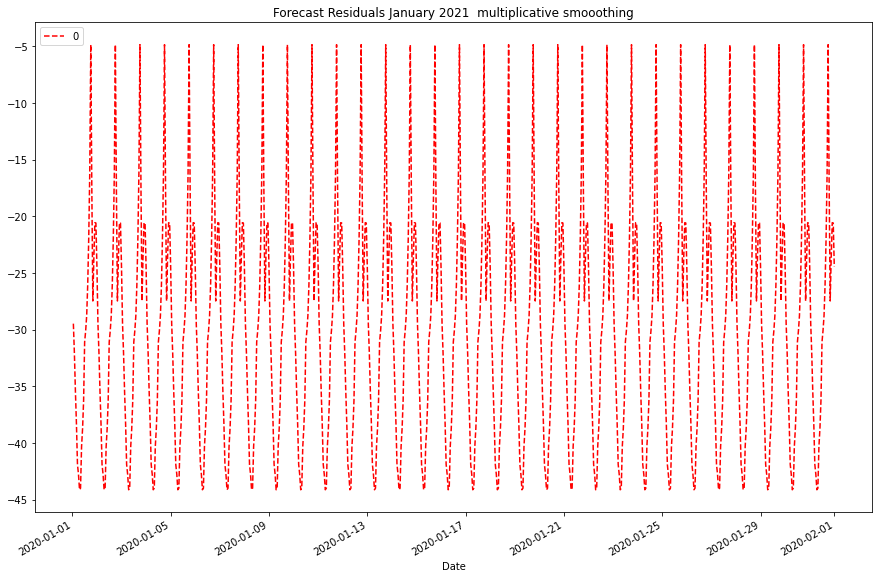

In [37]:
ax1= forecast_mul.plot(color = 'red',  linestyle = 'dashed', figsize=(15,10))



plt.title('Forecast Residuals January 2021  multiplicative smooothing')
plt.show()

The muliplicative method appears to have shifted the mean negatively and has increased variance so lets stick with the additive results

In [18]:
# Add the additive es residuals to the train and test 
train['fitted_residuals'] = residuals_tes.fittedvalues
test['predicted_residuals'] = forecast

In [19]:
# CHECK DATA SETS CONTIN VARIABLES WEVE ADDED
print(train.head())

                           mw  temp  hour  day  weekday  month  year  \
Date                                                                   
2017-02-01 00:53:00  1419.881  37.0     0    1        2      2  2017   
2017-02-01 01:53:00  1379.505  37.0     1    1        2      2  2017   
2017-02-01 02:53:00  1366.106  36.0     2    1        2      2  2017   
2017-02-01 03:53:00  1364.453  36.0     3    1        2      2  2017   
2017-02-01 04:53:00  1391.265  36.0     4    1        2      2  2017   

                     temp_norm  temp_normsq       fitted       APE  residuals  \
Date                                                                            
2017-02-01 00:53:00  -0.871499     0.759511  1340.273043  5.606664  79.607957   
2017-02-01 01:53:00  -0.871499     0.759511  1311.224494  4.949638  68.280506   
2017-02-01 02:53:00  -0.924494     0.854690  1313.105097  3.879706  53.000903   
2017-02-01 03:53:00  -0.924494     0.854690  1322.037175  3.108632  42.415825   
2017-02-0

In [20]:
print(test.head(10))

                           mw  temp  hour  day  weekday  month  year  \
Date                                                                   
2020-01-01 00:53:00  1363.428  31.0     0    1        2      1  2020   
2020-01-01 01:53:00  1335.975  29.0     1    1        2      1  2020   
2020-01-01 02:53:00  1296.817  30.0     2    1        2      1  2020   
2020-01-01 03:53:00  1288.403  30.0     3    1        2      1  2020   
2020-01-01 04:53:00  1292.263  31.0     4    1        2      1  2020   
2020-01-01 05:53:00  1318.124  31.0     5    1        2      1  2020   
2020-01-01 06:53:00  1342.334  31.0     6    1        2      1  2020   
2020-01-01 07:53:00  1365.210  30.0     7    1        2      1  2020   
2020-01-01 08:53:00  1385.602  31.0     8    1        2      1  2020   
2020-01-01 09:53:00  1413.973  32.0     9    1        2      1  2020   

                     temp_norm  temp_normsq    predicted        APE  \
Date                                                            

Add these predicted residuals to the predictions of energy usage from phase 3 linear regression to obtain a new dynamic energy prediction model. 

In [21]:
train['fitted_exps'] = train['fitted'] + train['fitted_residuals']
test['predicted_exps'] = test['predicted'] + test['predicted_residuals']

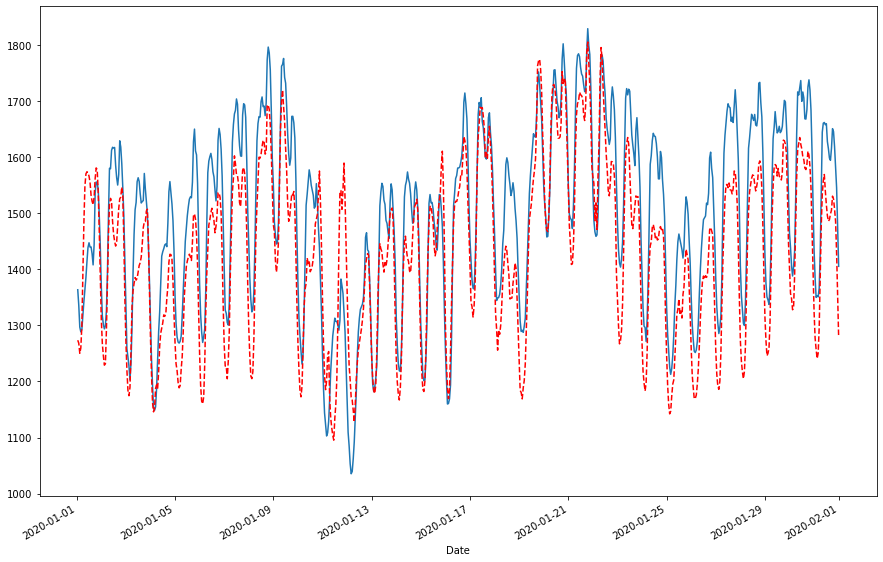

In [22]:
test['mw'].plot(figsize=(15,10))

test['predicted_exps'].plot(color = 'red', linestyle = 'dashed', figsize=(15,10))


plt.show()

In [23]:
train['APE_exps'] = abs((train['mw']-train['fitted_exps'])/train['mw'])*100
print("Combined TRAIN Least Squared and Exponential Squared Model MAPE is: ", train['APE_exps'].mean())

Combined TRAIN Least Squared and Exponential Squared Model MAPE is:  1.484198965472298


In [24]:
test['APE_exps'] = abs((test['mw']-test['predicted_exps'])/test['mw'])*100
print("Combined TEST Least Squared and Exponential Squared  Prediction Model MAPE is: ", test['APE_exps'].mean())

Combined TEST Least Squared and Exponential Squared  Prediction Model MAPE is:  5.54545097852837


THIS REPRESENTS A SIGNIFICANT IMPROVEMENT OVER THE ORIGINAL LEAST SQUARES PREDICTION MODEL
HOWEVER, DATA SMOOTHING TARGETTED THE INITIAL VARIABILITY OVER THE 24 HOUR PERIOD AND NOT OHER SEASONAL VARIATIONS.
THE ARIMA MODELS REPRESENT A MORE SOPHISTICATED APPROACH TO TIME SERIES/
SEASONAL DATA
IN ORDER TO VALIDATE WHETHER THE USE WILL POTENTIALLY IMPROVE THE MODEL 


In [29]:
mod = SARIMAX(train['residuals'], order=(2,0,0), seasonal_order=(0,1,1,24))
results = mod.fit()

print(results.summary())

C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                      SARIMAX Results                                       
Dep. Variable:                            residuals   No. Observations:                25536
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -127287.455
Date:                              Thu, 27 May 2021   AIC                         254582.910
Time:                                      11:01:27   BIC                         254615.498
Sample:                                           0   HQIC                        254593.447
                                            - 25536                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8113      0.003    270.417      0.000       0.805       0.817
ar.L2          0.07

C:\Users\Mike\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


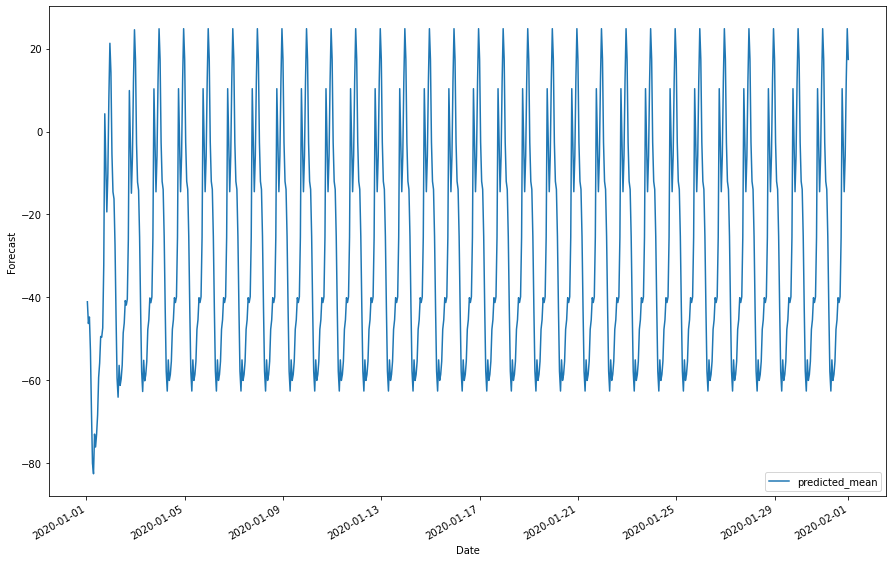

In [34]:
forecast = pd.DataFrame(residuals.forecast(744))
forecast.index = test.index.copy()

ax1 = forecast.plot( figsize=(15,10))

ax1.set_ylabel('Forecast')

plt.show()

In [32]:
train['fitted_ARIMA_residuals'] = results.predict()
test['predicted_ARIMA_residuals'] = forecast

In [33]:
train['fitted_ARIMA'] = train['fitted'] + train['fitted_ARIMA_residuals']
test['predicted_ARIMA'] = test['predicted'] + test['predicted_ARIMA_residuals']

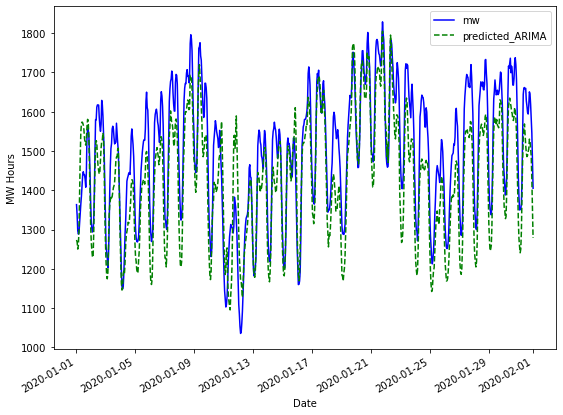

In [34]:
test['mw'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['predicted_ARIMA'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

CHECK MAPE VALUES FOR TRAINinG AND TEST DATA. THE COMBINED LEAST SQUARES AND EXPONENTIAL SMOOTHING MODEL HAD VALUES:
   TRAIN:  1.484198965472298 
   TEST:   5.54545097852837
    
AS CAN BE SEEN FROM THE RESULTS BELOW THERE IS A MARGINAL IMPROVEMENT IN
THE COMBINED LEAST SQUARES AND ARIMA MODELS ABILITY TO FIT THE TRAINing data and to PREDICT THE
TEST DATA

In [35]:
train['APE_ARIMA'] = abs((train['mw']-train['fitted_ARIMA'])/train['mw'])*100
print("Training Naive + ARIMA Model MAPE is: ", train['APE_ARIMA'].mean())

Training Naive + ARIMA Model MAPE is:  1.3663882695635658


In [36]:
test['APE_ARIMA'] = abs((test['mw']-test['predicted_ARIMA'])/test['mw'])*100
print("Naive + ARIMA Model MAPE is: ", test['APE_ARIMA'].mean())

Naive + ARIMA Model MAPE is:  5.54545097852837


In [ ]:
train.to_pickle('train4Mod.pki')
test.to_pickle('test4Mod.pki')

DID GET pmdarima installed running in a separate Jbook and with as many windows processes stopped as possible. Unfortunatly this is no task for an oldDell I5 laptop with 8gb memory.It was insufficient to execute sucessfully.  I hope to try it on a larger unix machine but that is not set up for condapython so that taks will have to wait. Refer
DataAnalysis4b

!pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

mod_auto = auto_arima(train['residuals'], start_p=0, start_q=0, max_p=3, max_q=3, 
                      start_P=2, start_Q=0, max_P=2, max_Q=0, m=24, 
                      seaonal=True, trace=True, d=0, D=1, error_action='warn', 
                      stepwise=True)